This Notebook is mainly an exploratory analysis of the Hearthstone Dataset. The main focus is to clean and sort the data in order to make further analysis more efficient.

In [3]:
## All the Libraries used

import os
import numpy as np
import json
import pandas as pd
from collections import Counter
import csv
import matplotlib.pyplot as plt
from sklearn import neighbors, metrics, grid_search, cross_validation
##import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model
import sklearn
from sklearn.ensemble import RandomForestRegressor



pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline

plt.style.use('ggplot')

In [4]:
## reading heartpwn dataset

data_df = pd.read_csv(os.path.join('data.csv'))
data_df

,craft_cost,date,deck_archetype,deck_class,deck_format,...,card_25,card_26,card_27,card_28,card_29
0,9740,2016-02-19,Unknown,Priest,W,...,2582,2683,2736,2568,2883
1,9840,2016-02-19,Unknown,Warrior,W,...,2064,2078,2510,2729,2736
2,2600,2016-02-19,Unknown,Mage,W,...,2064,2064,2078,38710,38710
3,15600,2016-02-19,Unknown,Warrior,W,...,336,2729,2729,2736,2760
4,7700,2016-02-19,Unknown,Paladin,W,...,374,2717,2717,2889,2889
...,...,...,...,...,...,...,...,...,...,...,...
346227,5480,2016-04-25,Unknown,Paladin,S,...,38745,38781,38781,38911,38911
346228,3840,2016-02-07,Unknown,Rogue,S,...,1158,1372,1651,2884,2884
346229,5580,2016-02-07,Unknown,Paladin,W,...,2883,2889,2901,2949,2951
346230,5160,2016-02-07,Unknown,Druid,S,...,2782,2782,2948,38319,38319


In [5]:
## reading card dataset

with open('refs.json') as file:
    refs = json.load(file)

refs = pd.DataFrame(refs)

In [6]:
data_df['date'] = pd.to_datetime(data_df['date'])

# Primary Analysis

In [7]:
print np.average(data_df.craft_cost, weights=(data_df.deck_format == 'S'))
print np.average(data_df.craft_cost, weights=(data_df.deck_format == 'W'))

6020.33807806
5280.34209956


On average, Standard decks cost more dust than Wild decks.

In [8]:
Counter(data_df.deck_format)

Counter({'S': 170786, 'W': 175446})

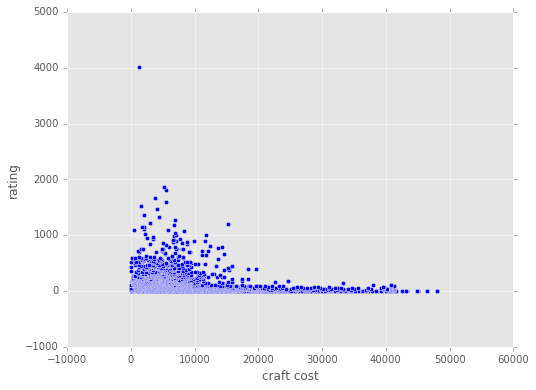

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(data_df.craft_cost, np.sort(data_df.rating.values))
plt.xlabel('craft cost', fontsize=12)
plt.ylabel('rating', fontsize=12)
plt.show()

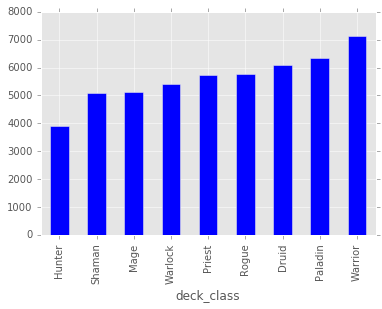

In [10]:
c = data_df.craft_cost.groupby(data_df.deck_class).mean()
c.sort_values(inplace=True)
c.plot(kind = 'bar')

From the graph, Warrior decks often cost the most to craft, whilst Hunter decks are the cheapest

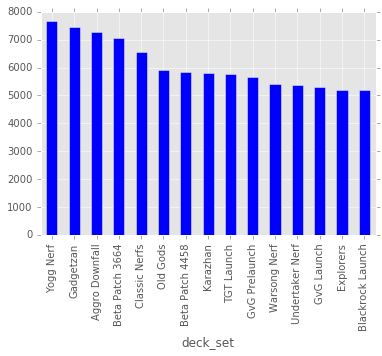

In [11]:
c = data_df.craft_cost.groupby(data_df.deck_set).mean()
c.sort_values(inplace=True, ascending = False)
c[:15].plot(kind = 'bar')

# Further Analysis


## Releases and meta

### Race

In [12]:
data_df = pd.read_csv(os.path.join('data.csv'))

with open('refs.json') as file:
    refs = json.load(file)

refs = pd.DataFrame(refs)

data_df['date'] = pd.to_datetime(data_df['date'])
refs.race.fillna('Normal', inplace=True)
data_df = data_df.drop(data_df.deck_type == 'Tavern Brawl')
refs.cost.fillna(0,inplace=True)

card_col = ['card_{}'.format(str(i)) for i in range(30)]

In [13]:
result = data_df.copy()
result = result.reset_index(drop = True)

for x in range(30):
    result = pd.merge(result, refs, left_on = result[card_col[x]], right_on = refs.dbfId, how = 'left')

In [14]:
## creating Race columns and its sum

races = refs.race.unique()
race_df = pd.DataFrame(index=result.index)
for x in range(len(races)):
    race_df[races[x]] = 0
    
dum = [result['race_x'],result['race_y']]
    
for x in range(len(result)):
    out = Counter(dum[0].ix[x]) + Counter(dum[1].ix[x])
    for i in range(len(races)):
        race_df = race_df.set_value(x, races[i], out[races[i]])

In [43]:
## Adding date and release to dataframe

race_df['date'] = result.date
race_df['deck_set'] = result.deck_set

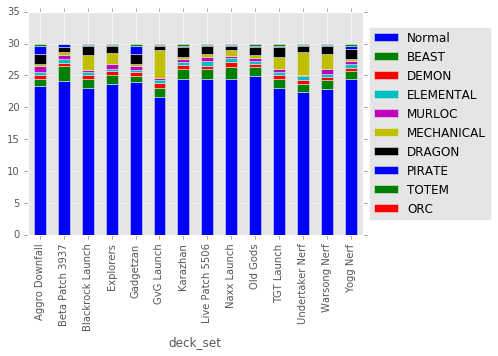

In [21]:
## Looking at Releases that contributed to the most deck creations and its race distribution

trial = race_df.copy()

threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = trial['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
trial['deck_set'].replace(to_remove, np.nan, inplace=True)
trial = trial.dropna(how = 'any')
trial.drop(['Beta Patch 3937'],axis = 0, inplace = True)
trial.drop(['Live Patch 5506'],axis = 0, inplace = True)

d = trial.groupby(trial.deck_set).mean()

d.plot(kind = 'bar',stacked = True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

- it's obvious that after GVG launch, the amount of Mechs ina deck increased because GVG pushed out a lot of mech cards.
- With the releasae of Gadgetzan, the average number of Dragon's increase due to popularization of Dragon Priest decks

### Card Cost

In [24]:
## dataframes used are from before

result_copy = result.copy()

In [38]:
## Creating cost columns and its sum

costs = refs.cost.unique()
cost_df = pd.DataFrame(index=result.index)
for x in range(len(costs)):
    cost_df[costs[x]] = 0
    
dum = [result_copy['cost_x'],result_copy['cost_y']]
    
for x in range(len(result_copy)):
    out = Counter(dum[0].ix[x]) + Counter(dum[1].ix[x])
    for i in range(len(costs)):
        cost_df = cost_df.set_value(x, costs[i], out[costs[i]])

In [42]:
## Adding date and release to dataframe

cost_df['date'] = result_copy.date
cost_df['deck_set'] = result_copy.deck_set

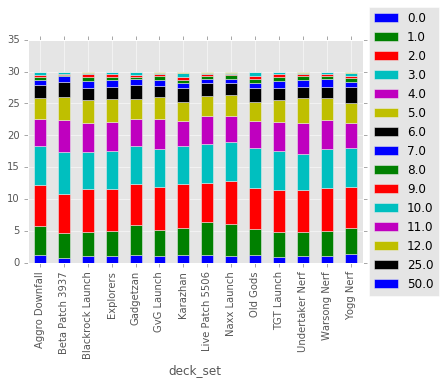

In [67]:
## Looking at Releases that contributed to the most deck creations and its race distribution

trial1 = cost_df.copy()

threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = trial1['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
trial1['deck_set'].replace(to_remove, np.nan, inplace=True)
trial1 = trial1.dropna(how = 'any')
trial1 = trial1.reindex_axis(sorted(trial1.columns), axis=1)

trial1.drop(['Beta Patch 3937'],axis = 0, inplace = True)
trial1.drop(['Live Patch 5506'],axis = 0, inplace = True)

b = trial1.groupby(trial1.deck_set).mean()

b.plot(kind = 'bar',stacked = True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

###  Class

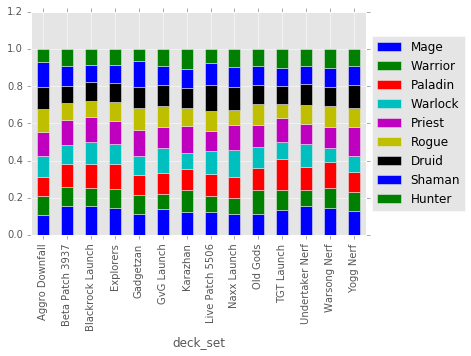

In [157]:
deck_df = result.copy()
deck_df = deck_df[['deck_class','deck_set']]

threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = deck_df['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
deck_df['deck_set'].replace(to_remove, np.nan, inplace=True)
deck_df = deck_df.dropna(how = 'any')
deck_df = deck_df.reset_index(drop = True)

difclass = deck_df.deck_class.unique()
for x in range(len(difclass)):
    deck_df[difclass[x]] = 0
    
for x in range(len(deck_df)):
    deck_df = deck_df.set_value(x, deck_df.ix[x][0], 1)    

b = deck_df.groupby(deck_df.deck_set).mean()

b.drop(['Beta Patch 3937'],axis = 0, inplace = True)
b.drop(['Live Patch 5506'],axis = 0, inplace = True)

b.plot(kind = 'bar',stacked = True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Deck Archetype

In [185]:
arch_df = result.copy()
arch_df = arch_df[['deck_archetype','deck_set']]

threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = arch_df['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
arch_df['deck_set'].replace(to_remove, np.nan, inplace=True)
arch_df = arch_df.dropna(how = 'any')
arch_df = arch_df[arch_df.deck_archetype != 'Unknown']
arch_df = arch_df.reset_index(drop = True)


archetype = arch_df.deck_archetype.unique()
for x in range(len(archetype)):
    arch_df[archetype[x]] = 0
    
for x in range(len(arch_df)):
    arch_df = arch_df.set_value(x, arch_df.ix[x][0], 1)    

b = arch_df.groupby(arch_df.deck_set).mean()

b.plot(kind = 'bar',stacked = True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

KeyboardInterrupt: 

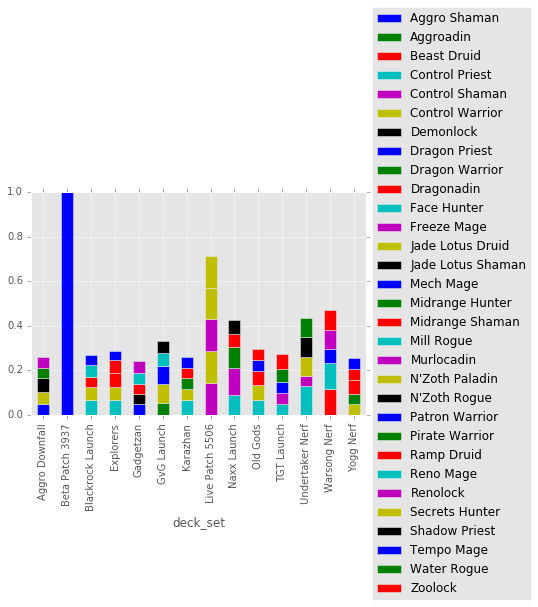

In [252]:
b_copy = b.copy()
b_copy = b_copy.transpose()

c = b_copy.apply(lambda x: x.sort_values(ascending=False).head(5), axis=0)
c = c.transpose()


c.plot(kind = 'bar',stacked = True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [253]:
c.drop(['Beta Patch 3937'],axis = 0, inplace = True)
c.drop(['Live Patch 5506'],axis = 0, inplace = True)

c.dropna(axis = 1, how = 'all', inplace = True)


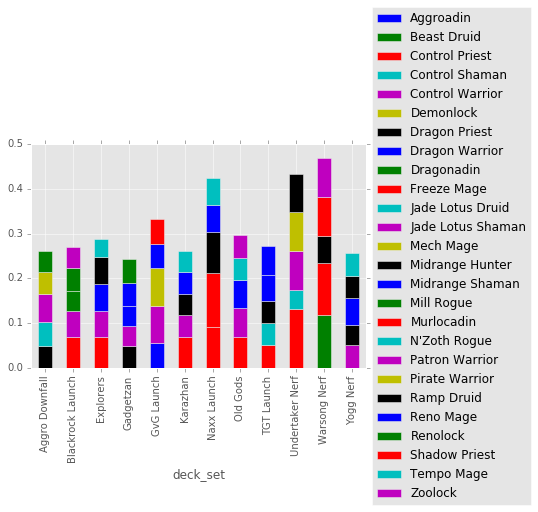

In [255]:
c.plot(kind = 'bar',stacked = True).legend(loc='center left', bbox_to_anchor=(1, 0.5))